# 1. Setup and Get Data

### 1.1 Collect finger images using OpenCV

In [16]:
import os
import time
import uuid
import cv2

In [17]:
IMAGES_PATH = os.path.join("data", "images")
number_images = 10

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.2 Label Images with LabelMe

In [18]:
# This step was performed using an app called "labelme" and i drew bounding boxes around my hand in each of them

### 2. Data Loading Function

In [19]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [20]:
images = tf.data.Dataset.list_files("data/images/*.jpg")

In [21]:
images.as_numpy_iterator().next()

b'data/images/990cff12-c81c-11ee-9204-02421f667b9f.jpg'

In [22]:
def load_image(x):
    init_img = tf.io.read_file(x)
    final_img = tf.io.decode_jpeg(init_img)
    
    return final_img

In [23]:
images = images.map(load_image)

In [24]:
images.as_numpy_iterator().next()

array([[[168, 122, 107],
        [171, 125, 110],
        [170, 124, 109],
        ...,
        [150, 132, 120],
        [150, 132, 122],
        [154, 136, 126]],

       [[171, 125, 110],
        [172, 126, 111],
        [171, 125, 110],
        ...,
        [151, 133, 121],
        [151, 133, 123],
        [154, 136, 126]],

       [[174, 128, 112],
        [173, 127, 111],
        [172, 126, 110],
        ...,
        [151, 133, 121],
        [151, 133, 123],
        [152, 134, 124]],

       ...,

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [ 44,  35,  30],
        [ 44,  35,  30],
        [ 44,  35,  30]],

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [ 41,  30,  26],
        [ 42,  31,  27],
        [ 41,  30,  26]],

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [ 39,  28,  24],
        [ 42,  28,  25],
        [ 41,  27,  24]]

In [25]:
image_generator = images.batch(4).as_numpy_iterator()

In [26]:
image_samples = image_generator.next()

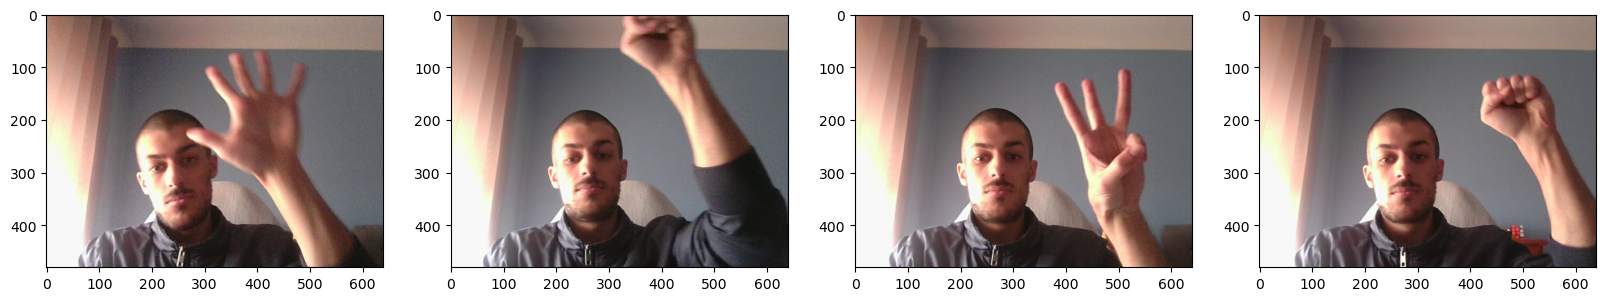

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(image_samples):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

### 3.1 Partition Images

In [28]:
# Train size, Val size, Test size
print(f"Train size: {120*0.7}\nVal size: {120*0.15}\nTest size: {120*0.15}")

Train size: 84.0
Val size: 18.0
Test size: 18.0


### 3.2 Partition Labels

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Pipeline

In [39]:
import albumentations as alb

In [40]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [29]:
img = cv2.imread(os.path.join('data','train', 'images','7893a9ac-c81c-11ee-9204-02421f667b9f.jpg'))

In [30]:
img.shape

(480, 640, 3)

In [31]:
with open(os.path.join('data', 'train', 'labels', '7893a9ac-c81c-11ee-9204-02421f667b9f.json'), 'r') as f:
    label = json.load(f)

In [32]:
print(f"Class: {label['shapes'][0]['label']}") # This is the class
print(f"Coordinates: {label['shapes'][0]['points']}") # These are the bounding box coordinates

Class: 0
Coordinates: [[263.1472081218274, 101.42131979695432], [418.4771573604061, 249.13705583756348]]


### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [33]:
coords = [0,0,0,0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]

In [34]:
coords

[263.1472081218274, 101.42131979695432, 418.4771573604061, 249.13705583756348]

In [35]:
coords = list(np.divide(coords, [640,480,640,480])) # Divide each coord by the corresponding width and height

In [36]:
coords # Rescaled coords

[0.41116751269035534,
 0.21129441624365483,
 0.6538705583756346,
 0.5190355329949239]

### 4.4 Apply Augmentations and View Results

In [48]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=[label['shapes'][0]['label']])

In [49]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [50]:
augmented["bboxes"][0]

(0.34612944162436543,
 0.21129441624365483,
 0.5888324873096447,
 0.5190355329949239)

In [51]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [640,480]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [640,480]).astype(int)), 
              (255,0,0), 2)

array([[[119, 128, 138],
        [118, 127, 137],
        [119, 131, 143],
        ...,
        [ 94, 117, 155],
        [ 93, 116, 154],
        [ 90, 113, 151]],

       [[124, 133, 143],
        [123, 131, 144],
        [121, 133, 145],
        ...,
        [ 97, 120, 158],
        [ 99, 122, 160],
        [ 98, 121, 159]],

       [[124, 132, 145],
        [125, 133, 146],
        [121, 133, 145],
        ...,
        [101, 122, 160],
        [101, 123, 164],
        [100, 122, 163]],

       ...,

       [[ 17,  16,  18],
        [ 18,  17,  19],
        [ 18,  17,  19],
        ...,
        [248, 248, 248],
        [248, 248, 248],
        [248, 248, 248]],

       [[ 18,  17,  21],
        [ 17,  16,  20],
        [ 17,  16,  18],
        ...,
        [248, 248, 248],
        [248, 248, 248],
        [248, 248, 248]],

       [[ 19,  18,  22],
        [ 18,  17,  21],
        [ 16,  15,  17],
        ...,
        [248, 248, 248],
        [248, 248, 248],
        [248, 248, 248]]

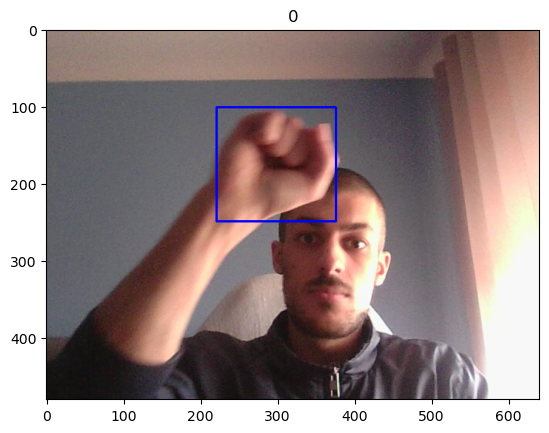

In [53]:
img = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(augmented['class_labels'][0])
plt.show()

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=[label['shapes'][0]['label']])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                #if os.path.exists(label_path):
                #    annotation['image'] = image
                #    annotation['bbox'] = augmented['bboxes'][0]
                #    annotation['class'] = int(label['shapes'][0]['label'])

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = int(label['shapes'][0]['label']) 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = int(label['shapes'][0]['label'])
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = int(label['shapes'][0]['label'])


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset Format

In [55]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [56]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [57]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [58]:
len(train_images), len(val_images), len(test_images)

(5040, 1080, 1080)

In [59]:
train_images.as_numpy_iterator().next()

array([[[0.42107844, 0.4       , 0.42058823],
        [0.2639093 , 0.2276348 , 0.24675246],
        [0.2329657 , 0.18590686, 0.20159313],
        ...,
        [0.08265931, 0.06697304, 0.06305147],
        [0.07267157, 0.06783088, 0.05343137],
        [0.07359069, 0.07751226, 0.05790441]],

       [[0.3720588 , 0.33909315, 0.3683211 ],
        [0.2579044 , 0.21427695, 0.23682599],
        [0.23431373, 0.1872549 , 0.20196079],
        ...,
        [0.09019608, 0.07450981, 0.07058824],
        [0.07892157, 0.075     , 0.06115196],
        [0.07843138, 0.07726716, 0.06556372]],

       [[0.31580883, 0.27267158, 0.30404413],
        [0.2773897 , 0.22990195, 0.246875  ],
        [0.25042892, 0.19160539, 0.2033701 ],
        ...,
        [0.06672794, 0.06280638, 0.05496323],
        [0.07450981, 0.07058824, 0.0627451 ],
        [0.07579657, 0.07579657, 0.06795343]],

       ...,

       [[0.32800245, 0.24564952, 0.26525736],
        [0.32916668, 0.24828431, 0.26501226],
        [0.34050244, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [60]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)
        
    return [label["class"]], label["bbox"]

### 6.2 Load Labels to Tensorflow Dataset

In [61]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [62]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [63]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [64]:
train_iterator = train_labels.as_numpy_iterator()

In [65]:
train_iterator.next()

(array([0], dtype=uint8),
 array([0.2426, 0.4685, 0.588 , 0.797 ], dtype=float16))

# 7. Combine Label and Image Samples

In [66]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels) # All good

(5040, 5040, 1080, 1080, 1080, 1080)

### 7.1 Create Final Datasets

In [67]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5500)
train = train.batch(8)
train = train.prefetch(4)

In [68]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)

In [69]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(8)
val = val.prefetch(4)

In [70]:
train.as_numpy_iterator().next()[1]

(array([[5],
        [0],
        [5],
        [0],
        [5],
        [4],
        [2],
        [5]], dtype=uint8),
 array([[0.545  , 0.3784 , 1.     , 0.992  ],
        [0.     , 0.445  , 0.2612 , 0.76   ],
        [0.     , 0.08295, 0.5073 , 0.8364 ],
        [0.3538 , 0.1809 , 0.6987 , 0.5093 ],
        [0.1749 , 0.1214 , 0.7515 , 0.7905 ],
        [0.3342 , 0.1077 , 0.885  , 0.72   ],
        [0.     , 0.2397 , 0.2766 , 0.87   ],
        [0.3818 , 0.3127 , 0.7476 , 0.872  ]], dtype=float16))

In [71]:
data_samples = train.as_numpy_iterator()

In [72]:
res = data_samples.next()

In [73]:
res[0].shape # 8 images in each batch

(8, 120, 120, 3)

In [74]:
res[1][0]

array([[4],
       [4],
       [5],
       [2],
       [3],
       [4],
       [2],
       [2]], dtype=uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/bruno/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


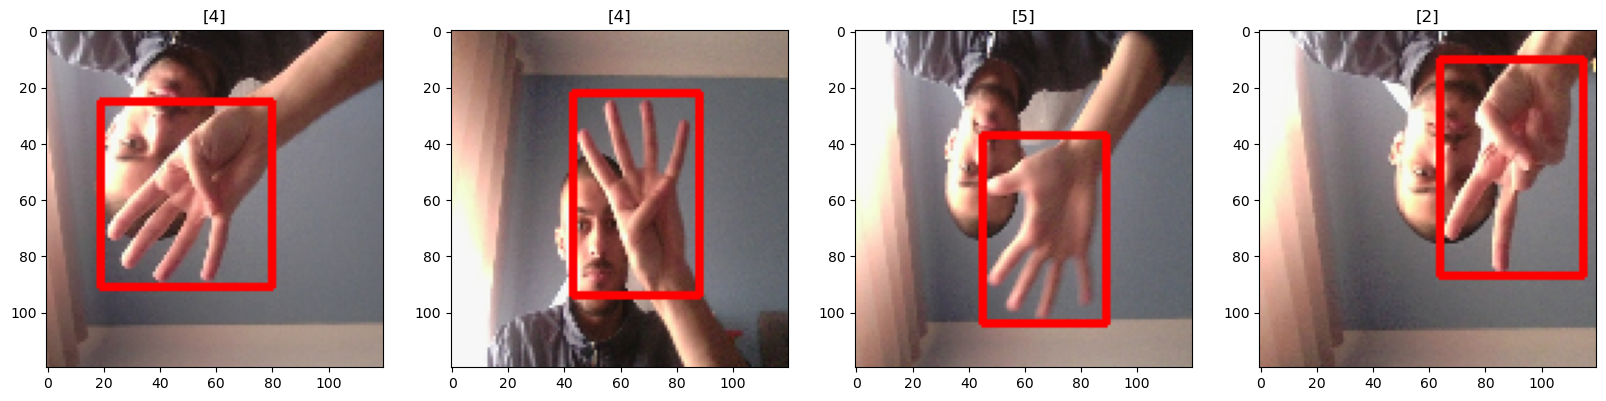

In [75]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                       (255,0,0), 2)

    ax[idx].imshow(sample_image)
    ax[idx].set_title(res[1][0][idx])

# Build the model on top VGG-16 NN using Transfer Learning

In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16

In [77]:
vgg = VGG16(include_top=False)

In [78]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [79]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(6, activation='softmax')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    fingertracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return fingertracker

In [80]:
fingertracker = build_model()

In [81]:
fingertracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [82]:
X, y = train.as_numpy_iterator().next()

In [83]:
X.shape

(8, 120, 120, 3)

In [84]:
classes, coords = fingertracker.predict(X)

1/1 [==============================] - 0s 379ms/step


In [85]:
classes, coords

(array([[0.16063087, 0.16596317, 0.07560435, 0.25082105, 0.24130112,
         0.10567944],
        [0.2006118 , 0.10936472, 0.12004314, 0.20299278, 0.24121459,
         0.12577297],
        [0.1699252 , 0.13494663, 0.07103173, 0.23958966, 0.22077924,
         0.16372758],
        [0.1774438 , 0.09672783, 0.07603314, 0.23529579, 0.29991654,
         0.11458301],
        [0.17717381, 0.14300232, 0.07849097, 0.1974167 , 0.2785824 ,
         0.12533382],
        [0.21662614, 0.12377021, 0.09844536, 0.33042622, 0.1456644 ,
         0.08506764],
        [0.17359051, 0.14316629, 0.13058716, 0.2645454 , 0.17408192,
         0.11402869],
        [0.1528213 , 0.19188073, 0.07909801, 0.22952107, 0.18850204,
         0.15817682]], dtype=float32),
 array([[0.49873346, 0.4823934 , 0.7922379 , 0.53499544],
        [0.53253746, 0.4653909 , 0.7481444 , 0.685279  ],
        [0.44475755, 0.47822854, 0.8157727 , 0.58481747],
        [0.5362953 , 0.4030021 , 0.73567253, 0.6077237 ],
        [0.45018908, 0.

# 9. Define Losses and Optimizers

In [86]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [87]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.1 Create localization loss and classification loss

In [88]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [89]:
classloss = tf.keras.losses.SparseCategoricalCrossentropy()
regressloss = localization_loss

In [92]:
regressloss(y[1], coords).numpy()

3.0793831

In [93]:
classloss(y[0], classes).numpy()

1.9040818

# 10. Train

### 10.1 Create Custom Model Class

In [94]:
class FingerTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            y_true = tf.reshape(y[0], [-1])
            y_pred = classes
            
            batch_classloss = self.closs(y_true, y_pred)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        y_true = tf.reshape(y[0], [-1])
        y_pred = classes
        
        batch_classloss = self.closs(y_true, y_pred)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [95]:
model = FingerTracker(fingertracker)

In [96]:
model.compile(opt, classloss, regressloss)

In [97]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [98]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
630/630 [==============================] - 554s 874ms/step - total_loss: 0.4243 - class_loss: 0.4382 - regress_loss: 0.2052 - val_total_loss: 0.2341 - val_class_loss: 0.2599 - val_regress_loss: 0.1041
Epoch 2/10
630/630 [==============================] - 414s 655ms/step - total_loss: 0.0664 - class_loss: 0.0233 - regress_loss: 0.0548 - val_total_loss: 0.8069 - val_class_loss: 0.0830 - val_regress_loss: 0.7654
Epoch 3/10
630/630 [==============================] - 417s 660ms/step - total_loss: 0.0395 - class_loss: 0.0083 - regress_loss: 0.0353 - val_total_loss: 0.3091 - val_class_loss: 0.2077 - val_regress_loss: 0.2052
Epoch 4/10
630/630 [==============================] - 416s 658ms/step - total_loss: 0.0297 - class_loss: 0.0045 - regress_loss: 0.0275 - val_total_loss: 0.1009 - val_class_loss: 0.0012 - val_regress_loss: 0.1003
Epoch 5/10
630/630 [==============================] - 419s 663ms/step - total_loss: 0.0253 - class_loss: 0.0036 - regress_loss: 0.0235 - val_total_loss:

### 10.2 Plot Performance

In [99]:
hist.history

{'total_loss': [0.1193590760231018,
  0.030099330469965935,
  0.007037235423922539,
  0.011841868981719017,
  0.0037242250982671976,
  0.00836815033107996,
  0.014903973788022995,
  0.004746581427752972,
  0.004973628558218479,
  0.0043099611066281796],
 'class_loss': [0.07587330788373947,
  0.0018435309175401926,
  0.0011403374373912811,
  0.0004188698367215693,
  0.0005655334098264575,
  0.0009785830043256283,
  0.0005948094185441732,
  0.00029237830312922597,
  0.000254702172242105,
  0.00031689065508544445],
 'regress_loss': [0.08142241835594177,
  0.02917756512761116,
  0.006467066705226898,
  0.011632434092462063,
  0.003441458335146308,
  0.007878858596086502,
  0.014606568962335587,
  0.004600392188876867,
  0.004846277646720409,
  0.0041515156626701355],
 'val_total_loss': [0.23410528898239136,
  0.8069239258766174,
  0.30907365679740906,
  0.10087412595748901,
  0.02430017665028572,
  0.48220881819725037,
  0.03343877196311951,
  0.017093461006879807,
  0.24594728648662567,
 

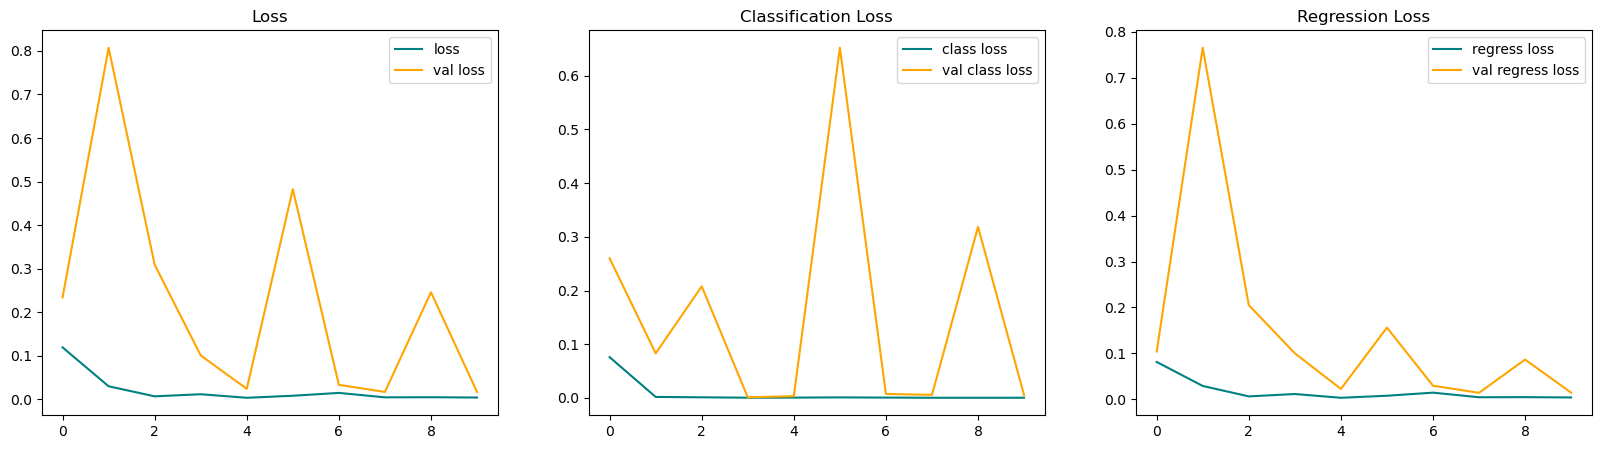

In [100]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions on the Test Set

In [101]:
test_data = test.as_numpy_iterator()

In [112]:
test_sample = test_data.next()

In [113]:
yhat = fingertracker.predict(test_sample[0])

1/1 [==============================] - 0s 138ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


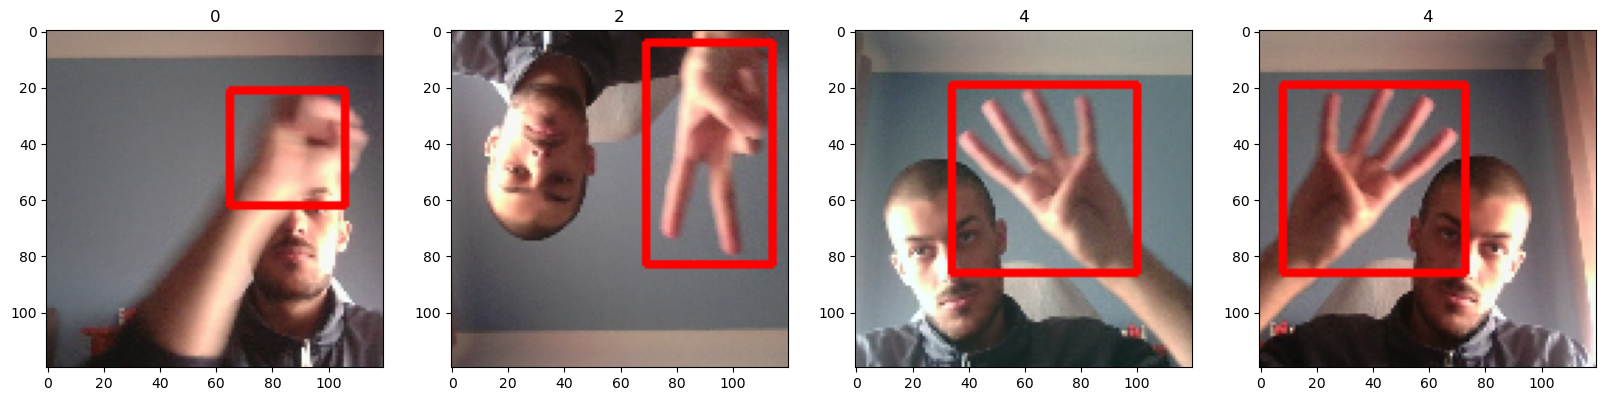

In [114]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)
    
    ax[idx].set_title(yhat[0][idx].argmax())
    ax[idx].imshow(sample_image)

### 11.1 Save the Model

In [115]:
from tensorflow.keras.models import load_model

In [116]:
fingertracker.save("fingertracker_final.h5")

/home/bruno/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 12. Real Time Detection

In [117]:
import cv2
import tensorflow as tf
import numpy as np

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = fingertracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    #if yhat[0] > 0.5: 
    # Controls the main rectangle
    cv2.rectangle(frame,
                  tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                        (255,0,0), 2)
    # Controls the label rectangle
    cv2.rectangle(frame, 
                  tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                [0,-30])),
                  tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                [80,0])), 
                        (255,0,0), -1)

    # Controls the text rendered
    cv2.putText(frame, str(yhat[0].argmax()), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                           [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()